图像卷积

In [1]:
#互相关运算
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X,K):
    """计算二维互相关运算"""
    h,w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1,X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i + h,j:j + w] *  K).sum()
    return Y

In [2]:
X = torch.arange(9).reshape(3,3)
K = torch.arange(4).reshape(2,2)
corr2d(X,K)

tensor([[19., 25.],
        [37., 43.]])

实现二维卷积

In [3]:
class Conv2D(nn.Module):
    def __init__(self,kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self,X):
        return corr2d(X,self.weight) + self.bias

卷积层的一个简单应用：检测图像中不同颜色的边缘

In [4]:
X = torch.ones(6,8)
X[:,2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [5]:
K = torch.tensor([[1.0,-1.0]])

In [6]:
#边缘检测
Y = corr2d(X,K)
Y
#输出Y中的1代表从白色到黑色的边缘，-1代表从黑色到白色的边缘

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [7]:
#卷积核K只能检测垂直边缘
corr2d(X.t(),K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

学习由X生成Y的卷积核

In [8]:
conv2d = nn.Conv2d(1,1,kernel_size=(1,2),bias=False)

X = X.reshape((1,1,6,8))  #1,1--通道，批量
Y = Y.reshape((1,1,6,7))
lr =  3e-2  #学习率
for i in range(10):
    Y_hat = conv2d(X)  #预测值
    l = (Y_hat - Y)**2
    conv2d.zero_grad()
    l.sum().backward()
    #梯度下降
    conv2d.weight.data[:] -= 3e-2 * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'batch {i+1},loss {l.sum():.3f}')

batch 2,loss 8.830
batch 4,loss 1.690
batch 6,loss 0.369
batch 8,loss 0.097
batch 10,loss 0.031


In [9]:
conv2d.weight.data.reshape((1,2))

tensor([[ 0.9692, -1.0014]])

卷积层的填充与步幅

填充

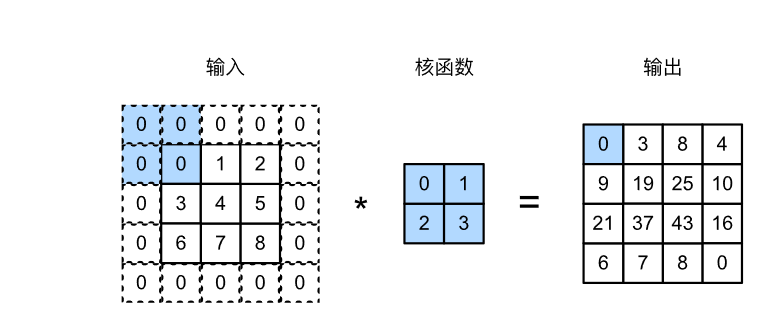

In [5]:
#在所有侧边填充1个像素
#创建一个3X3的二维卷积层，并在所有侧边填充一个像素
#给定高度和宽度为8的输入，则输出的高度和宽度也是8。
import torch
from torch import nn

def comp_conv2d(conv2d,X):
    #这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1,1) + X.shape) 
    Y = conv2d(X)
    #省去前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

#每一边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1)
X = torch.rand(size=(8,8))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

In [6]:
#当卷积核的高度和宽度不同时，我们可以填充不同的高度和宽度
#使输出和输入具有相同的高度和宽度
conv2d = nn.Conv2d(1,1,kernel_size=(5,3),padding=(2,1))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

步幅

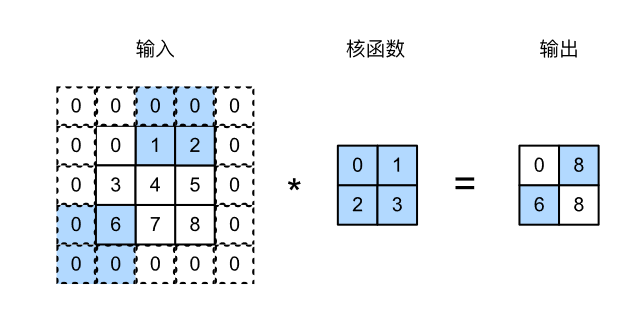

In [7]:
#将高度和宽度的步幅设置为2，从而将输入的高度和宽度减半。
conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1,stride=2)
comp_conv2d(conv2d,X).shape

torch.Size([4, 4])

In [8]:
conv2d = nn.Conv2d(1,1,kernel_size=(3,5),padding=(0,1),stride=(3,4))
comp_conv2d(conv2d,X).shape

torch.Size([2, 2])

多输入多输出通道

In [9]:
#多输入通道
import torch
from d2l import torch as d2l

def corr2d_multi_in(X,K):
    #先遍历"X"和"K"的第0个维度（通道维度）
    #再把它们加在一起
    return sum(d2l.corr2d(X,K) for X,K in zip(X,K))

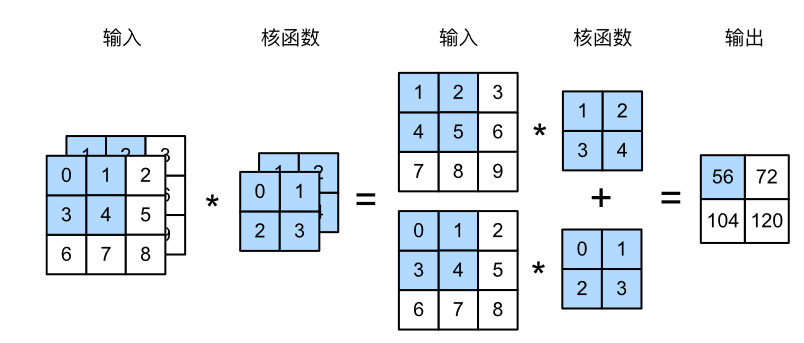

In [11]:
X = torch.tensor([[[0.0,1.0,2.0],[3.0,4.0,5.0], [6.0, 7.0, 8.0]],
                [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])
corr2d_multi_in(X,K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [12]:
#多输出通道
def corr2d_multi_in_out(X,K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X,k) for k in K],0)

#通过将核张量K与K+1（K中每个元素加1）和K+2连接起来，
#构造了一个具有3个输出通道的卷积核。
K = torch.stack((K,K + 1,K + 2),0)
K.shape

torch.Size([3, 2, 2, 2])

In [13]:
corr2d_multi_in_out(X,K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

1x1卷积

In [14]:
#使用全连接层实现1x1卷积。
#请注意，我们需要对输入和输出的数据形状进行调整
def corr2d_multi_in_out_1x1(X,K):
    c_i,h,w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i,h * w))
    K = K.reshape((c_o,c_i))
    #全连接层中的矩阵乘法
    Y = torch.matmul(K,X)
    return Y.reshape((c_o,h,w))

In [15]:
X = torch.normal(0,1,(3,3,3))
K = torch.normal(0,1,(2,3,1,1))

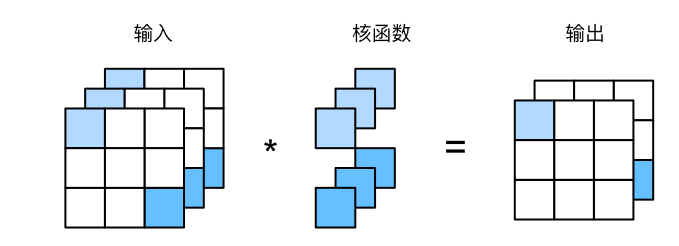

In [16]:
Y1 = corr2d_multi_in_out_1x1(X,K)
Y1

tensor([[[ 0.8955, -2.8628,  2.6140],
         [ 0.5868, -0.3042, -1.9740],
         [ 1.2940, -3.5069, -0.9455]],

        [[-1.2129,  4.5959, -4.0737],
         [ 0.3791,  1.2205,  2.4024],
         [-0.9198,  3.3949, -1.0026]]])

In [17]:
Y2 = corr2d_multi_in_out(X,K)
Y2

tensor([[[ 0.8955, -2.8628,  2.6140],
         [ 0.5868, -0.3042, -1.9740],
         [ 1.2940, -3.5069, -0.9455]],

        [[-1.2129,  4.5959, -4.0737],
         [ 0.3791,  1.2205,  2.4024],
         [-0.9198,  3.3949, -1.0026]]])

In [18]:
Y1 == Y2

tensor([[[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]]])